# NDVI Calculation

In [1]:
import sys
sys.path.append('../')

In [25]:
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import lithops
import time
import shutil
import pylab
import os
import gc
from rasterio.io import MemoryFile
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
from lithops import Storage

import cloudbutton_geospatial.s2froms3 as s2froms3
from cloudbutton_geospatial.utils import notebook as notebook_utils
from cloudbutton_geospatial.io_utils.ndvi import get_ndvi_params, ndvi_calculation, ndvi_tile_sentinel, get_subset_raster, lonlat_to_utm, get_poly_within
from cloudbutton_geospatial.io_utils.plot import tiff_overview, plot_map

%matplotlib inline

## Input parameters

Select the date interval in which tiles will be processed:

In [3]:
from_date, to_date = notebook_utils.pick_date_range()

DatePicker(value=datetime.date(2019, 9, 17), description='From day')

DatePicker(value=datetime.date(2021, 9, 16), description='To day')

Select the tile's cloud percentage threshold:

In [4]:
percentage = notebook_utils.pick_percentage_slider()

IntSlider(value=0, continuous_update=False, description='Percentage of cloudiness')

Select the area which delimites the tiles you want to process (left click to mark a point in the map, right click to erase current selection):

In [5]:
map_region = notebook_utils.MapRegion()

Map(center=[39.60595289727246, -122.82804126978336], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [6]:
coord = map_region.get_region()[0] #[-122.72001061072717, 39.25990481501755] 
lat = coord[1]  # latitude
lon = coord[0]  # longitude

start_date = from_date.value  # Start date to search images
end_date = to_date.value  # End date to search images
what = ['B04', 'B08']  # What we want to download
cc = percentage.value  # Minimum cloud cover on each image, 25 is 25%

print([lat, lon], start_date, end_date, what, cc)

[39.55800070006127, -122.61826429016692] 2019-09-17 2021-09-16 ['B04', 'B08'] 0


In [7]:
 map_region.get_region()

[[-122.61826429016692, 39.55800070006127],
 [-122.61826429016692, 39.55800070006127]]

## Get Sentinel-2 packages

In [8]:
storage = lithops.storage.Storage()

In [9]:
# Get scenes from intital date
scenes_f1 = s2froms3.get_scene_list(lon=lon, lat=lat,
                                    start_date=start_date,
                                    end_date=start_date,
                                    what=what,
                                    cloud_cover_le=cc)
print(f'Found scenes {start_date}:', scenes_f1)

# get scenes from end date
scenes_f2 = s2froms3.get_scene_list(lon=lon, lat=lat,
                                    start_date=end_date,
                                    end_date=end_date,
                                    what=what,
                                    cloud_cover_le=cc)
print(f'Found scenes {end_date}:', scenes_f2)

scene = scenes_f1[-1]
scene_band = rasterio.open('s3://'+scene[0])
windows = list(scene_band.block_windows())

Found scenes 2019-09-17: [('sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EJ/2019/9/S2A_10SEJ_20190917_0_L2A/B04.tif', 'sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EJ/2019/9/S2A_10SEJ_20190917_0_L2A/B08.tif')]
Found scenes 2021-09-16: [('sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EJ/2021/9/S2A_10SEJ_20210916_0_L2A/B04.tif', 'sentinel-cogs/sentinel-s2-l2a-cogs/10/S/EJ/2021/9/S2A_10SEJ_20210916_0_L2A/B08.tif')]


In [10]:
obj = storage.get_object('sentinel-cogs', scene[0].replace('sentinel-cogs/', ''))
obj2 = storage.get_object('sentinel-cogs', scene[1].replace('sentinel-cogs/', ''))
get_sz = len(obj) + len(obj2)

In [11]:
print(str(get_sz) + " bytes")
mb = get_sz / 2**20
print(str(mb) + " megabytes")
gb = mb / 1000
print(str(gb) + " gigabytes")

462804282 bytes
441.36455726623535 megabytes
0.44136455726623536 gigabytes


In [12]:
def calculate_ndvi(scene, ij_window, storage):

    ij, window = ij_window
    band_4_s3_loc, band_8_s3_loc = scene
    band_path = band_4_s3_loc.split('/')
    ndvi_local = f'/tmp/{band_path[7]}_{ij}_NDVI.tif'
    jpg_local = f'/tmp/{band_path[7]}_{ij}_NDVI.jpg'

    # generate nir and red objects as arrays in float64 format
    # Read from S3 to lambda
    
    get_t0 = time.time()
    band4 = rasterio.open('s3://'+band_4_s3_loc)  # red
    band8 = rasterio.open('s3://'+band_8_s3_loc)  # nir
    
    
    profile = band4.profile
    profile.update(dtype='float64')
    profile.update(width=window.width)
    profile.update(height=window.height)

    with rasterio.open(ndvi_local, 'w', **profile) as dst:
        red = band4.read(1, window=window).astype('float64')
        nir = band8.read(1, window=window).astype('float64')
        get_t1 = time.time()
        ndvi = (np.where((nir + red) == 0., 0, (nir - red) / (nir + red))).astype('float64')
        ndvi_mean = np.mean(ndvi, axis=0)
        dst.write(ndvi, 1)
        ndvi[0][0] = -1
        ndvi[0][1] = 1
        plt.imsave(jpg_local, ndvi, cmap="RdYlGn")
    
    # THROUGHPUT WRITE    
    with open(jpg_local, 'rb') as jpg_temp:
        put_t0 = time.time()
        co_jpg = storage.put_cloudobject(jpg_temp.read(), key=jpg_local.replace('/tmp/', ''))
        put_t1 = time.time()
        
        obj_metadata = storage.head_object('daniel-lithops-geospatial', jpg_local.replace('/tmp/', ''))
        put_sz = float(obj_metadata.get('content-length'))
    
    write_bandwidth_mb = put_sz / (put_t1 - put_t0) / 1e6
          
    stats = {
        'put': {'t0': put_t0, 't1': put_t1, 'bandwidth': write_bandwidth_mb, 'size': put_sz},
        'get': {'t0': get_t0, 't1': get_t1, 'bandwidth': 0, 'size': 0},
    }
    
    return ndvi_local, ndvi_mean, co_jpg, stats 


def compute_ndvi_diff(old_scene, new_scene, ij_window, storage):

    ij, window = ij_window
    band_path = new_scene[0].split('/')
    jpg_diff_local = f'/tmp/{band_path[7]}_{ij}_NDVI_DIFF.jpg'

    ndvi_local_f1, ndvi_mean_f1, co_jpg_f1, stats_f1 = calculate_ndvi(old_scene, ij_window, storage)
    ndvi_local_f2, ndvi_mean_f2, co_jpg_f2, stats_f2 = calculate_ndvi(new_scene, ij_window, storage)     
          
    ndvi_old = rasterio.open(ndvi_local_f1)
    ndvi_new = rasterio.open(ndvi_local_f2)

    profile = ndvi_old.profile
    profile.update(dtype='float64')
    profile.update(width=window.width)
    profile.update(height=window.height)

    no = ndvi_old.read(1).astype('float64')
    nn = ndvi_new.read(1).astype('float64')
    ndvi_cmp = ((nn - no) * (nn + no)).astype('float64')
    ndvi_cmp[0][0] = -1
    ndvi_cmp[0][1] = 1
    plt.imsave(jpg_diff_local, ndvi_cmp, cmap="RdYlGn")

    # esto realmente solo lo usa para mostrar la imagen en el codigo final, se pueden ahorrar muchos puts con esto 
    #with open(jpg_diff_local, 'rb') as jpg_diff_file:
        #co_jpg_diff = storage.put_cloudobject(jpg_diff_file, key=jpg_diff_local.replace('/tmp/', ''))

    co_jpg_diff=""
    return ij_window, co_jpg_f1, co_jpg_f2, co_jpg_diff, stats_f1, stats_f2

Using the selected parameters, get the identifiers of the selected tiles from Sentinel-2:

In [ ]:
fexec = lithops.FunctionExecutor(
        backend='aws_lambda',
        storage='aws_s3',
        log_level='DEBUG',
        monitoring='rabbitmq',
        runtime='aws_lambda/lithops-ndvi-v39:01'  # Runtime for AWS Lambda
)
    #runtime_memory=1024,
    #max_workers=10,

iterdata = [(scenes_f1[0], scenes_f2[0], wd) for wd in windows]
fexec.map(compute_ndvi_diff, iterdata)
results = fexec.get_result()

In [ ]:
# Plots
fexec.plot(dst='C:\\Users\\alega\\Desktop\\lithops' + str([lat, lon]))

In [ ]:
list_throughput = []
for worker in results:
    list_throughput.append(worker[4])
    list_throughput.append(worker[5])

list_throughput

In [ ]:
write_results

In [ ]:
read_results = [stat['get'] for stat in list_throughput]
write_results = [stat['put'] for stat in list_throughput]

In [ ]:
def create_agg_bdwth_plot(res_write, res_read, dst):
    def compute_times_rates(start_time, d):
        x = np.array(d)
        tzero = start_time
        tr_start_time = x[:, 0] - tzero
        tr_end_time = x[:, 1] - tzero
        rate = x[:, 2]

        N = len(tr_start_time)
        runtime_rate_hist = np.zeros((N, len(runtime_bins)))

        for i in range(N):
            s = tr_start_time[i]
            e = tr_end_time[i]
            a, b = np.searchsorted(runtime_bins, [s, e])
            if b-a > 0:
                runtime_rate_hist[i, a:b] = rate[i]

        return {'start_time': tr_start_time,
                'end_time': tr_end_time,
                'rate': rate,
                'runtime_rate_hist': runtime_rate_hist}
    
    start_time = min((min(t['t0'] for t in res_write), (min(t['t0'] for t in res_read)))) - 1

    fig = pylab.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1)
    for datum, l in [(res_write, 'Aggregate Write Bandwidth'), (res_read, 'Aggregate Read Bandwidth')]:
        mb_rates = [(res['t0'], res['t1'], res['bandwidth']) for res in datum]
        max_seconds = int(max([mr[1]-start_time for mr in mb_rates])*1.2)
        max_seconds = 8 * round(max_seconds/8)
        runtime_bins = np.linspace(0, max_seconds, max_seconds)

        mb_rates_hist = compute_times_rates(start_time, mb_rates)

        ax.plot(mb_rates_hist['runtime_rate_hist'].sum(axis=0)/1000, label=l)

    ax.set_xlabel('Execution Time (sec)')
    ax.set_ylabel("GB/sec")
    ax.set_xlim(0, )
    ax.set_ylim(0, )
    pylab.legend()
    pylab.grid(True, axis='y')

    dst = os.path.expanduser(dst) if '~' in dst else dst

    fig.tight_layout()
    fig.savefig(dst, format='pdf')

In [ ]:
# Statistics: 
startTime = set()
endTime = set()

for future in fexec.futures:
    for key in future.stats.keys():
        if key.endswith("worker_func_start_tstamp"):
            startTime.add(future.stats[key])
        if key.endswith("worker_end_tstamp"):
            endTime.add(future.stats[key])
            
            
duration = max(endTime) - min(startTime)

In [ ]:
# Duration: 
print(duration)

In [ ]:
# Number of workers:
numberWorkers=len(fexec.futures)
numberWorkers

In [ ]:
# THROUGHPUT READ
size_total_read = 0
for value in read_results:
    size_per_worker = get_sz / numberWorkers
    size_total_read = size_total_read + size_per_worker
    value['size'] = size_per_worker
    value['bandwidth'] = size_per_worker / (value.get('t1') - value.get('t0')) / 1e6

In [ ]:
# Size total write
size_total_write = 0
for value in write_results:
    size_total_write = size_total_write + value.get('size')

In [ ]:
read_results

In [ ]:
create_agg_bdwth_plot(read_results, write_results, fexec.executor_id + '-storage-kpi.pdf')

In [ ]:
# Throughput read numeric:
throughput_interpolation = size_total_read / duration  # Bytes/second
print(f"Throughput: {throughput_interpolation / 1024**2} MiB/s")

In [ ]:
# Throughput write numeric:
throughput_interpolation = size_total_write / duration  # Bytes/second
print(f"Throughput: {throughput_interpolation / 1024**2} MiB/s")

In [24]:
read_results

[{'t0': 1654794731.4684596,
  't1': 1654794734.0678723,
  'bandwidth': 1.4714203738291278,
  'size': 3824828.776859504},
 {'t0': 1654794737.3055403,
  't1': 1654794738.9684892,
  'bandwidth': 2.300027919788666,
  'size': 3824828.776859504},
 {'t0': 1654794734.5747843,
  't1': 1654794737.4326801,
  'bandwidth': 1.3383373559047478,
  'size': 3824828.776859504},
 {'t0': 1654794741.8726866,
  't1': 1654794743.3355887,
  'bandwidth': 2.6145487505079856,
  'size': 3824828.776859504},
 {'t0': 1654794735.0756824,
  't1': 1654794737.9782171,
  'bandwidth': 1.3177547011512811,
  'size': 3824828.776859504},
 {'t0': 1654794742.696182,
  't1': 1654794744.197554,
  'bandwidth': 2.5475555191174197,
  'size': 3824828.776859504},
 {'t0': 1654794735.1707919,
  't1': 1654794737.8923607,
  'bandwidth': 1.405376466959641,
  'size': 3824828.776859504},
 {'t0': 1654794742.3802657,
  't1': 1654794743.693429,
  'bandwidth': 2.912683314934645,
  'size': 3824828.776859504},
 {'t0': 1654794734.9016845,
  't1': 16

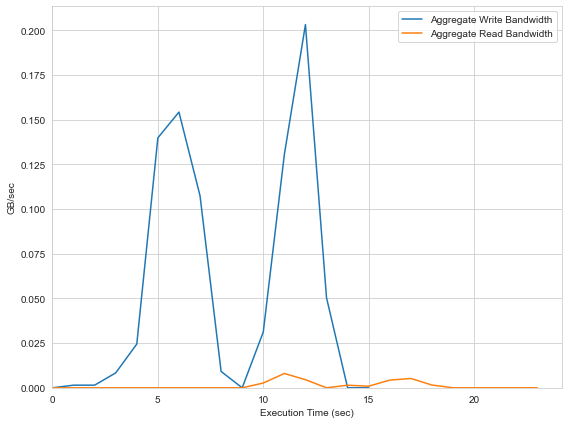

In [26]:
create_agg_bdwth_plot(read_results, write_results, fexec.executor_id + '-storage-kpi.pdf')

In [32]:
# Throughput read numeric:
throughput_interpolation = size_total_read / duration  # Bytes/second
print(f"Throughput: {throughput_interpolation / 1024**2} MiB/s")

Throughput: 45.86134039229429 MiB/s


In [34]:
# Throughput write numeric:
throughput_interpolation = size_total_write / duration  # Bytes/second
print(f"Throughput: {throughput_interpolation / 1024**2} MiB/s")

Throughput: 2.111045103190282 MiB/s


In [27]:
keys = storage.list_keys(bucket='daniel-lithops-geospatial')

In [28]:
for key in keys:
    storage.delete_object(bucket='daniel-lithops-geospatial', key=key)

KeyboardInterrupt: 

## Get and plot the computed jpg diff tile image

In [ ]:
def get_jpg(data):
    file = '_'.join(data[0][1].key.split('_')[:5])
    
    if 'DIFF' in data[0][1].key:
        out_file = f'AwsData/{file}_NDVI_DIFF.jpg'
    else:
        out_file = f'AwsData/{file}_NDVI.jpg'
        
    jpgs = {}

    def get_window(data):
        ij_window, co_jpg = data
        row = ij_window[0][0]
        col = ij_window[0][1]
        jpg_stream = fexec.storage.get_cloudobject(co_jpg, stream=True)

        if row not in jpgs:
            jpgs[row] = [None]*11

        jpgs[row][col] = Image.open(jpg_stream)

    with ThreadPoolExecutor(max_workers=len(data)) as ex:
        fs = ex.map(get_window, data)

    new_im = Image.new('RGB', (scene_band.width, scene_band.height))

    x_offset = 0
    y_offset = 0

    for row in sorted(jpgs.keys()):
        for im in jpgs[row]:
            new_im.paste(im, (x_offset, y_offset))
            x_offset += im.size[0]
        x_offset = 0
        y_offset += im.size[1]
        
    thumbnail_zise = (640, 640)
    new_im.thumbnail(thumbnail_zise)

    #fig = plt.figure(figsize=(10, 10))
    #plt.title(out_file)
    #plt.imshow(new_im)
    images[out_file] = new_im

In [ ]:
co_jpgs_f1 = [(res[0], res[1]) for res in results]
co_jpgs_f2 = [(res[0], res[2]) for res in results]
co_jpgs_diff = [(res[0], res[3]) for res in results]

images = {}
with ThreadPoolExecutor(max_workers=3) as ex:
    fs = ex.map(get_jpg, [co_jpgs_f1, co_jpgs_f2, co_jpgs_diff])

f, ax = plt.subplots(1,3, figsize=(18, 18))
i = 0
for j in sorted(images.keys()):
    ax[i].set_title(j)
    ax[i].imshow(images[j])
    i = i+1
plt.show() 